##### Import

In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
# import pickle

In [2]:
from simple_veloce_reduction import veloce_config, veloce_reduction_tools, veloce_extraction, veloce_wavecalib

In [3]:
# Presentation-ready matplotlib global settings (run in new cell)
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.major.size': 6,
    'ytick.minor.size': 3,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.0,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.0,
    'legend.fontsize': 16,
    'legend.frameon': False,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.6,
})

# Note: enable minor ticks per-axes when needed with ax.minorticks_on()

In [4]:
# from matplotlib import rcParams
# # rcParams["figure.dpi"] = 300
# rcParams["savefig.dpi"] = 300
# rcParams["xtick.direction"] = "in"
# rcParams["ytick.direction"] = "in"
# rcParams["xtick.top"] = True
# rcParams["ytick.right"] = True
# rcParams["font.size"] = 12
# rcParams["lines.linewidth"] = 1.5

### Set up
It is done outside of my extraction function

In [6]:
# use config as always but just for the single arm as the notebook is not set up to run 'all'

In [7]:
config = {
    # primary information for the reduction
    'reduce': 'run',  # what to reduce options: 'run', 'night', or 'file'
    'date': '230726',  # date of the observation (YYMMDD), if 'reduce' is 'night' or 'file'
    'filename': '26jul20137.fits',  # name of the file to reduce, if 'reduce' is 'file'
    'science_targets': ['10700'],  # file containing a list of science targets
    'calib_type': 'arcTh',  # Wavelength calibration to use SimLC, SimThXe (not implemented), Interpolate_lc (LC not implemented), Interpolate_th (Th, not implemented), or Static
    # secondary information for the reduction
    'use_log': False,  # True or False, if True the code will use the log files to identify the files
    'arm': 'green',  # Which arm to reduce 'all', 'red', 'green' or 'blue'
    'amplifier_mode': 4,  # 2 or 4
    'validate_trace': True,  # True or False, if True the code will cross-correlate FibFlat with reference to determine offset of the trace(s)
    'sim_calib': True,  # Flag indicating if the simultaneous calibration was used True or False
    'plot_diagnostic': True,  # True or False
    'scattered_light': False,  # try to remove scattered light (background) True or False
    'flat_field': False,  # these are fiber flats (white light fiber spectrum) used for pixel sensitivity True or False

    # part responsible for the paths
    # 'input_dir': 'Data/Raw/CSV_Run',  # path to the directory with data (the input directory should include subdirectories for nights)
    'input_dir': '/home/usqobserver2/VeloceData/TauCeti_archive/',  # path to the directory with data (the input directory should include subdirectories for nights)
    'output_dir': 'Data/Extracted/Step-by-step',  # path to the directory where extracted data will be stored (i.e. output directory)

    # below are paths where code will store intermediate files and diagnostics
    # by default they are set as subdirectories of output directory with extracted data
    'master_dir': 'Default',  # directory for master images for night/run
    'wavelength_calibration_dir': 'Default',  # directory for wavelength calibration related files for the night/run
    'trace_shift_dir': 'Default',  
    'plot_dir': 'Default',  # directory for diagnostic plots

    # below are paths where the code will look for internal files
    # leave as default unless you know what you are doing
    'trace_dir': 'Default',  # path to the directory with traces to be extracted
    'trace_file': 'Default',  # filename of the file with traces to be extracted
    'wave_dir': 'Default',  # path to the directory with reference wavelength solution
}

veloce_paths = veloce_config.VelocePaths.from_config(config)
science_targets = veloce_config.load_target_list(config['science_targets'])

##### Directory structure <br>
It helps me pass all the paths between compnents but is less relevant in this step-by-step deminstration.<br>
I'm not quite happy of my approach to it but I hope it works.

In [8]:
veloce_paths = veloce_config.VelocePaths.from_config(config)

In [9]:
obs_list = veloce_config.load_night_logs(
            science_targets, veloce_paths, config)

In [10]:
# obs_list

### Begining of data extraction

All below happens in the extraction function:


In [11]:
# select correct dir name based on arm
arm = config['arm']
if arm == 'blue':
    ccd = 'ccd_1'
elif arm == 'green':
    ccd = 'ccd_2'
elif arm == 'red':
    ccd = 'ccd_3'
else:
    raise ValueError('Unsupported arm')

Traces based on calibration fiber traces for ThAr from the manual to extract all expected orders. <br>
Position for the run is validated against a template from community science verification run.

In [12]:
trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl')
# trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(trace_filename)

In [13]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(
        arm=arm, wave_calib_slice=traces.wave_calib_slice, wave_path=veloce_paths.wave_dir)

In [14]:
# traces.set_summing_range([(low-4, high-2) for low, high in zip(traces.summing_ranges_lower, traces.summing_ranges_upper)])

In [15]:
# ### check if the trace needs to be updated (i.e. it was derived for different date and the phisical position on the detector changed)
# if config['validate_trace']:
#     # load fiber flat for trace validation
#     traces = veloce_extraction.get_trace_shift(traces, veloce_paths, arm, config['amplifier_mode'], config['sim_calib'], obs_list)

In [16]:
# load spectrum
spectrum_filename = os.path.join(veloce_paths.input_dir, config['date'], ccd, config['filename'])
with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    hdr = hdul[0].header

Removing overscan bias and merging the four quadrants.<br>

In [17]:
%matplotlib inline

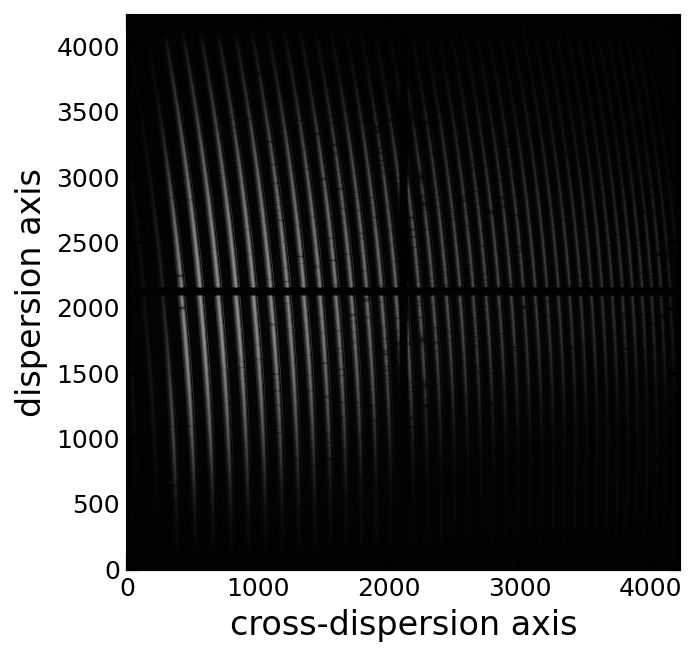

In [18]:
plt.close()
plt.imshow(image_data, aspect='equal', cmap='gray', norm='symlog', origin='lower')
plt.xlabel('cross-dispersion axis')
plt.ylabel('dispersion axis')
plt.show()

In [19]:
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr, arm, config['amplifier_mode'], overscan_range=32)

In [16]:
%matplotlib widget

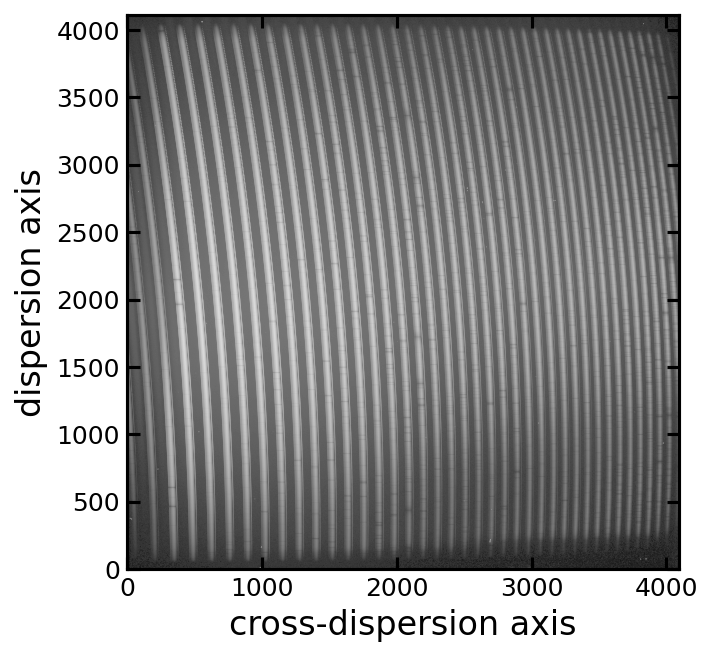

In [20]:
plt.close('all')
plt.imshow(image_subtracted_bias, aspect='equal', cmap='gray', norm='symlog', origin='lower')
plt.xlabel('cross-dispersion axis')
plt.ylabel('dispersion axis')
plt.show()

Extracting orders based on the loaded traces.<br>
Below is a plot from my examination tool presenting cross section of extracted order. The extracted data is sum of counts from region between dashed lines (exclusive). I'm not ploting anything during bulk reduction.

In [18]:
if config['flat_field']:
    flat, norm_flat = veloce_extraction.get_flat(veloce_paths, arm, config['amplifier_mode'], config['date'], obs_list)
    image_subtracted_bias_flatcorr, hdr = veloce_reduction_tools.flat_field_correction(image_subtracted_bias, norm_flat, hdr)

In [19]:
if config['scattered_light']:
    image_subtracted_bias, hdr = veloce_extraction.remove_scattered_light(image_subtracted_bias, hdr, traces)

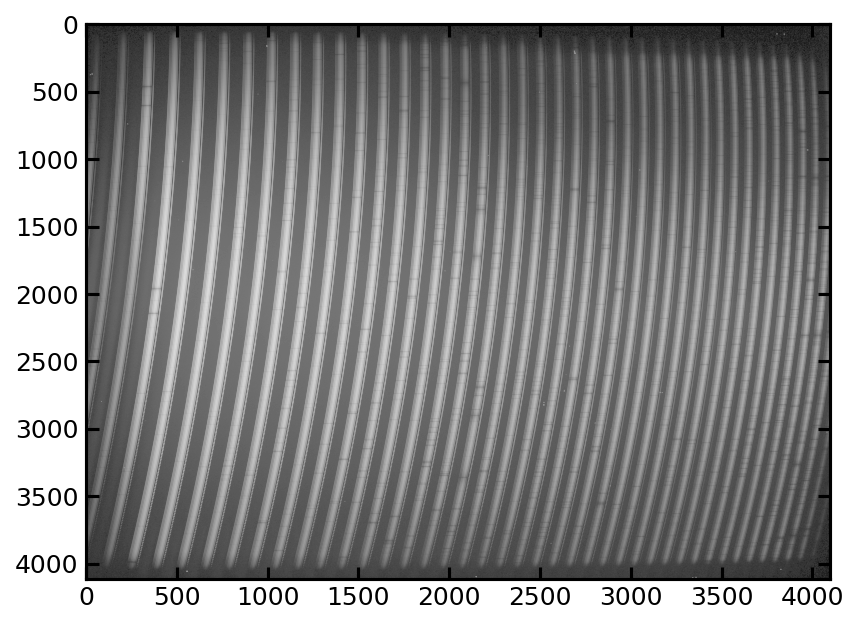

In [21]:
plt.close('all')
plt.imshow(image_subtracted_bias, aspect='auto', cmap='gray', norm='symlog')
plt.show()

In [22]:
extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
        image_subtracted_bias, traces, remove_background=False)

In [ ]:
# _extracted_science_orders, _extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
#         image_subtracted_bias, traces, remove_background=False)

In [ ]:
# extracted_science_orders_flatcorr, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
#         image_subtracted_bias_flatcorr, traces, remove_background=False)

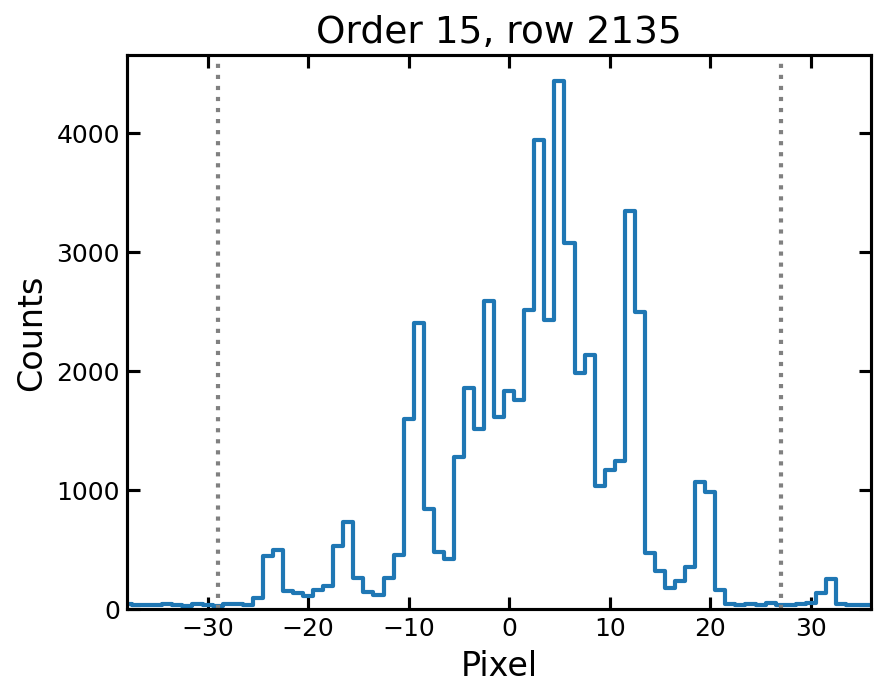

In [24]:
order = 15
row = 2135
plt.close('all')
veloce_reduction_tools.plot_order_cross_section(image_subtracted_bias, traces, order, plot_type=row)
plt.xlim(-1*(traces.summing_ranges_lower[order]+10), traces.summing_ranges_upper[order]+10)
plt.ylim(0,)
plt.savefig(f'order_{ORDER[order]}_row_{row}.png')

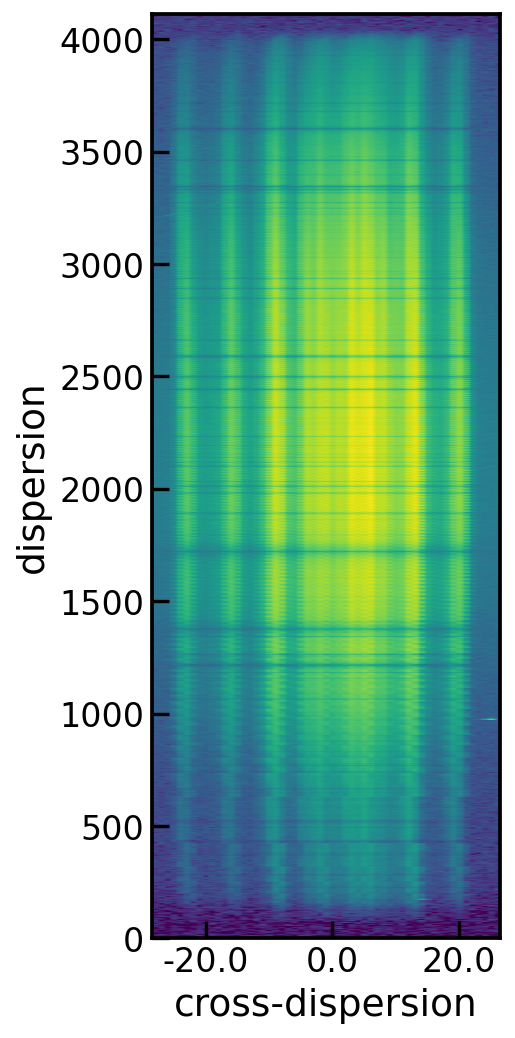

<Figure size 960x720 with 0 Axes>

In [29]:
order = 15
lower_range, upper_range = float(traces.summing_ranges_lower[order]), float(traces.summing_ranges_upper[order])
    
xticks = np.arange(lower_range % 20, lower_range + upper_range + 1, 20)
xtick_labels = np.arange(-lower_range + (lower_range % 20), upper_range + 1, 20)

plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(3, 8))
ax.imshow(extracted_order_imgs[order], aspect='auto', norm='log', origin='lower')
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('cross-dispersion')
ax.set_ylabel('dispersion')
# plt.tight_layout()
plt.show()
plt.savefig(f'../Plots/{science_targets[0]}_step_by_step_extraction_extracted_order_{ORDER[order]}.png')

In [25]:
# config['calib_type'] = 'SimLC'
config['calib_type'] = 'Static'

Wave calibration based on the precomputed solution from Chris. There is one order offset between my traces and wave solutions (it is incomplete order and should be removed from traces for final version).

In [26]:
if config['calib_type'] == 'Static':
    # load static wave calibration based on ThAr (from Chris Tinny)
    ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(
        arm=arm, wave_calib_slice=traces.wave_calib_slice, wave_path=veloce_paths.wave_dir)
    vacuum_wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_science_orders, Y0, COEFFS, traces=traces)                   
    final_flux = extracted_science_orders
    final_wave = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]
elif config['calib_type'] == 'SimLC':
    vacuum_wave, final_flux = veloce_wavecalib.calibrate_simLC(
                extracted_science_orders, veloce_paths, image_subtracted_bias,
                hdr, arm, plot=config['plot_diagnostic'])
    final_wave = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]
elif config['calib_type'] == 'arcTh':
    final_wave = veloce_wavecalib.calibrate_absolute_Th(
        traces, veloce_paths, obs_list,
        config['date'], arm, config['amplifier_mode'],
        plot=config['plot_diagnostic'], plot_filename='step-by-step',
        th_linelist_filename='Default')
    final_flux = extracted_science_orders
else:
    raise ValueError('Unsupported calibration type')



In [32]:
vacuum_wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_science_orders, Y0, COEFFS, traces=traces)                   
_final_flux = extracted_science_orders
_final_wave = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]

In [27]:
# if config['calib_type'] == 'Static':
#     # load static wave calibration based on ThAr (from Chris Tinny)
#     ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(
#         arm=arm, wave_calib_slice=traces.wave_calib_slice, wave_path=veloce_paths.wave_dir)
#     vacuum_wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_science_orders, Y0, COEFFS, traces=traces)                   
#     final_flux_flatcorr = extracted_science_orders_flatcorr
#     final_wave_flatcorr = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave]
# elif config['calib_type'] == 'SimLC':
#     vacuum_wave_flatcorr, final_flux_flatcorr = veloce_wavecalib.calibrate_simLC(
#                 extracted_science_orders_flatcorr, veloce_paths, image_subtracted_bias,
#                 hdr, arm, plot=config['plot_diagnostic'])
#     final_wave_flatcorr = [veloce_reduction_tools.vacuum_to_air(wave) for wave in vacuum_wave_flatcorr]
# elif config['calib_type'] == 'arcTh':
#     final_wave_flatcorr = veloce_wavecalib.calibrate_absolute_Th(
#         traces, veloce_paths, obs_list,
#         config['date'], arm, config['amplifier_mode'],
#         plot=config['plot_diagnostic'], plot_filename='step-by-step',
#         th_linelist_filename='Default')
#     final_flux_flatcorr = extracted_science_orders_flatcorr
# else:
#     raise ValueError('Unsupported calibration type')

In [28]:
# filename = os.listdir(veloce_paths.output_dir)[0]
# wave, flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(veloce_paths.output_path, filename))

In [29]:
# order = 1
# fig, ax = plt.subplots(1, 2, figsize=(12,6))
# ax[0].step(final_wave[order], final_flux[order], where='mid')
# ax[0].step(_final_wave[order], _final_flux[order], where='mid')
# ax[0].set_xlabel('Wavelength [nm]')
# ax[0].set_ylabel('Flux [ADU]')
# ax[1].step(final_wave[order], final_flux[order], where='mid')
# ax[1].step(_final_wave[order], _final_flux[order], where='mid')
# plt.xlim(588.7, 589.85)
# # plt.ylim(80000, 140000)
# ax[1].set_xlabel('Wavelength [nm]')
# ax[1].set_ylabel('Flux [ADU]')

In [30]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(
        arm=arm, wave_calib_slice=traces.wave_calib_slice, wave_path=veloce_paths.wave_dir)

Text(0, 0.5, 'Counts [ADU]')

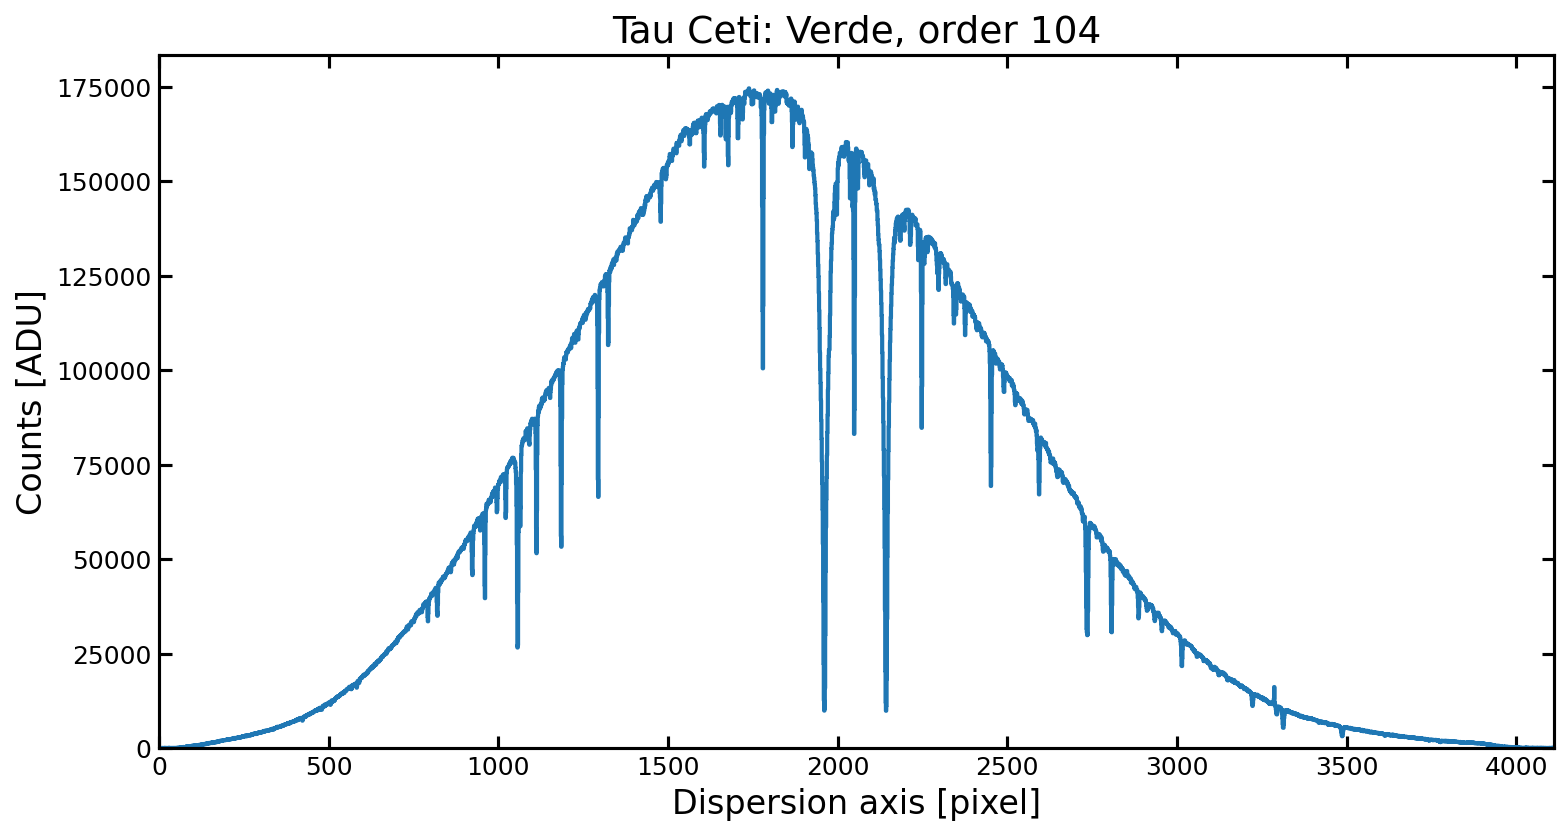

In [27]:
order = 1
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_title(f'Tau Ceti: Verde, order {ORDER[order]}')
pix = np.arange(len(extracted_science_orders[order]))
ax.step(pix, extracted_science_orders[order], where='mid', color='C0')
# ax.step(final_wave_flatcorr[order], final_flux_flatcorr[order], where='mid')
ax.set_xlim(np.nanmin(pix), np.nanmax(pix))
ax.set_ylim(0,)
ax.set_xlabel('Dispersion axis [pixel]')
ax.set_ylabel('Counts [ADU]')
# plt.savefig(f'../Plots/{science_targets[0]}_step_by_step_extraction_pix_order_{ORDER[order]}.png')

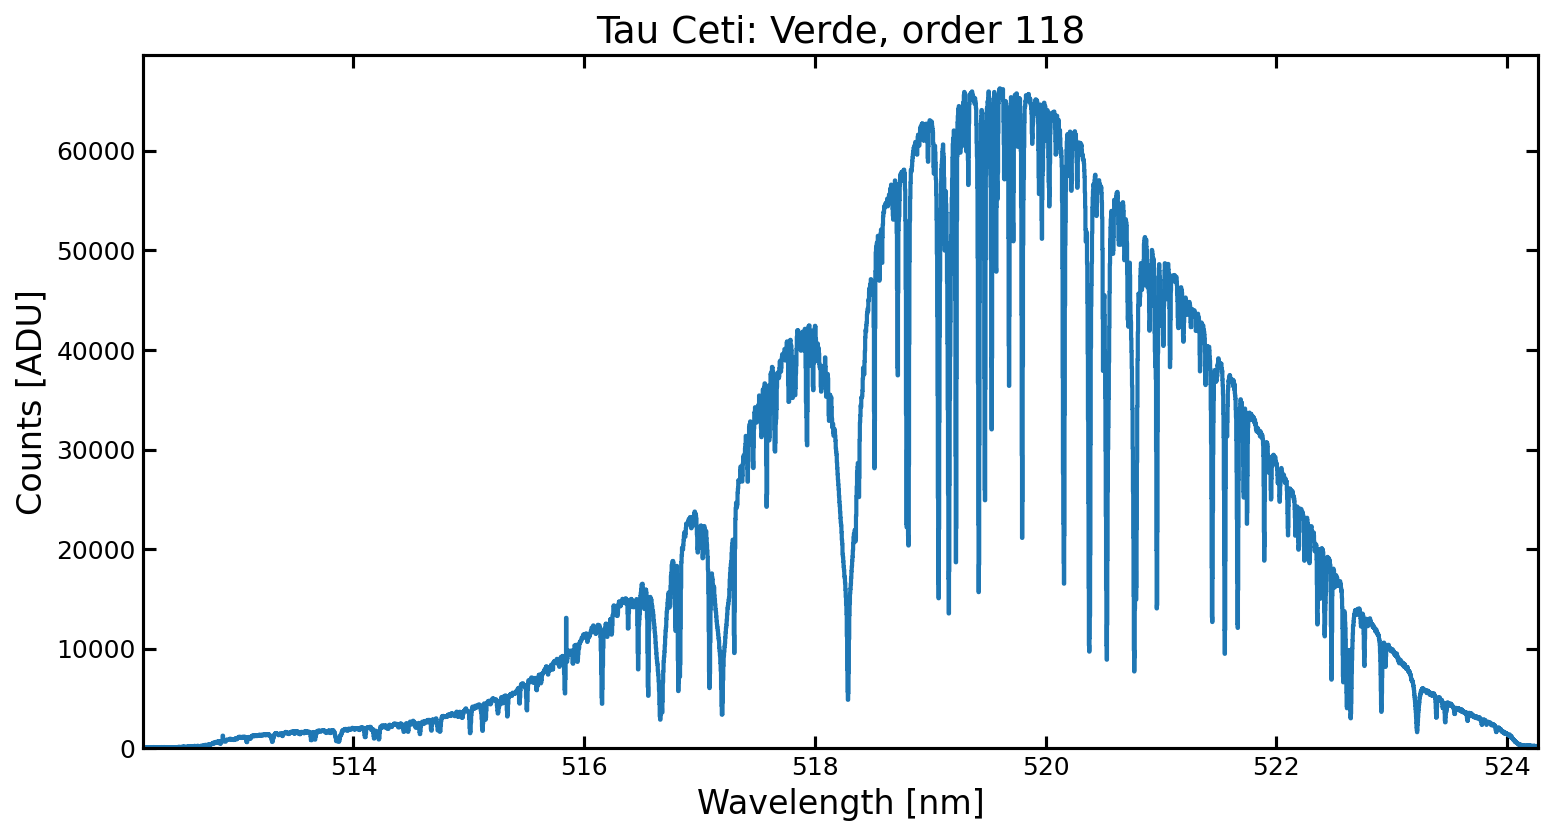

In [28]:
order = 15
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_title(f'Tau Ceti: Verde, order {ORDER[order]}')
ax.step(final_wave[order], final_flux[order], where='mid', color='C0')
# ax.step(vacuum_wave[order], final_flux[order], where='mid')
# ax.step(final_wave_flatcorr[order], final_flux_flatcorr[order], where='mid')
ax.set_xlim(np.nanmin(final_wave[order]), np.nanmax(final_wave[order]))
ax.set_ylim(0,)
# ax.axvline(589.0, color='red', linestyle='--', label='Na I D2')
# ax.axvline(589.6, color='orange', linestyle='--', label='Na I D1')
# ax.axvline(518.36, color='grey', linestyle='--', label='Ca I 518.36 nm')
# ax.axvline(517.27, color='grey', linestyle='--', label='Ca I 517.27 nm')
# ax.axvline(516.73, color='grey', linestyle='--', label='Ca I 517.27 nm')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Counts [ADU]')
plt.savefig(f'../Plots/{science_targets[0]}_step_by_step_extraction_wave_calib_order_{ORDER[order]}.png')

In [29]:
# save extracted spectrum as fits file
fits_filename = os.path.join(veloce_paths.output_dir, f"veloce_{arm}_{config['filename']}")
veloce_reduction_tools.save_extracted_spectrum_fits(
    filename=fits_filename, wave=final_wave, flux=final_flux, hdr=hdr)

'/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Data/Extracted/Step-by-step/veloce_green_26jul20137.fits'

In [48]:
%matplotlib widget

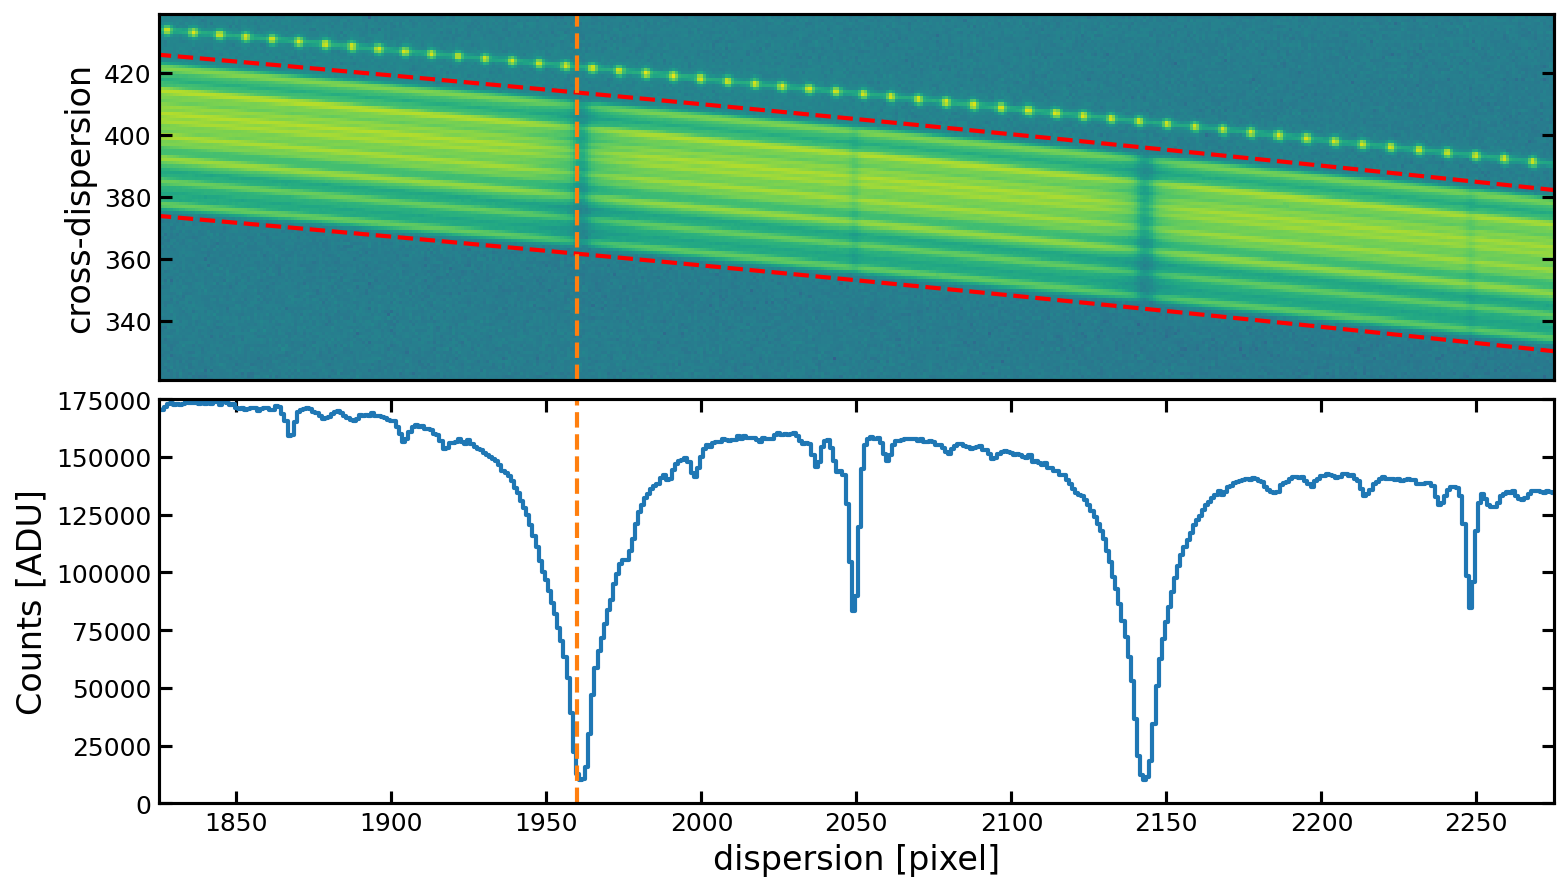

In [30]:
plt.close('all')
order = 1
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
axes[0].imshow(image_subtracted_bias.T, aspect='equal', norm='symlog', origin='lower')
axes[0].plot(traces.y[order], traces.x[order] - traces.summing_ranges_lower[order], 'r--')
axes[0].plot(traces.y[order], traces.x[order] + traces.summing_ranges_upper[order] - 2, 'r--')
axes[0].axvline(1960, c='C1', ls='--')
axes[0].set_ylabel('cross-dispersion')
# axes[0].set_xlim(1121, 1839)  # Mg triplet
axes[0].set_xlim(1825, 2275)  # Na lines
axes[0].set_xticks([])
# axes[0].set_ylim(2111, 2224)  # Mg triplet
axes[0].set_ylim(321, 439)  # Na lines

axes[1].step(traces.y[order], extracted_science_orders[order], where='mid', color='C0')
axes[1].axvline(1960, c='C1', ls='--')
# axes[1].set_xlim(1121, 1839)  # Mg triplet
axes[1].set_xlim(1825, 2275)  # Na lines
# axes[1].set_ylim(0, 56500) # Mg triplet
axes[1].set_ylim(0, 175050) # Na lines
axes[1].set_xlabel('dispersion [pixel]')
axes[1].set_ylabel('Counts [ADU]')

# remove vertical space so subplots touch and make the join visually seamless
plt.subplots_adjust(hspace=0)
# axes[0].spines['bottom'].set_visible(False)
# axes[1].spines['top'].set_visible(False)
# axes[0].tick_params(bottom=False, labelbottom=False)
# axes[1].tick_params(top=False)

plt.show()
# plt.savefig(f'../Plots/{science_targets[0]}_step_by_step_extraction_image_and_extracted_order_{ORDER[order]}.png')

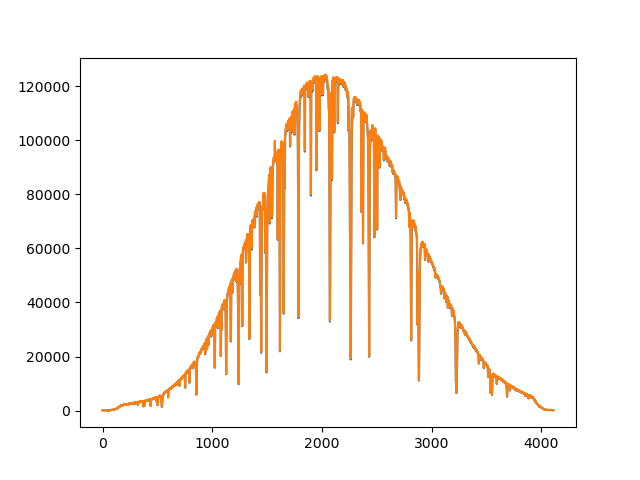

In [ ]:
plt.close('all')
# plt.plot(_extracted_science_orders[10])
plt.plot(extracted_science_orders[10])
plt.show()

In [12]:
%matplotlib inline

In [13]:
def wavelength_to_rgb(nm, alpha=0.7):

    '''
    Takes a wavelength of visible light
    between 380 and 780 nanometres inclusive.
    Values outside this range will raise a ValueError.
    Returns a list of corresponding RGB values.
    Based on Dan Bruton's Fortran implementation.

    modified from https://github.com/CodeDrome/wavelength-to-rgb-python.git
    '''

    # if nm < 396 or nm > 940:

        # raise ValueError("nm argument must be between 380 and 780")

    gamma = 0.8
    # max_intensity = 255
    factor = 0

    rgb = {"R": 0, "G": 0, "B": 0}
    # Extended/extrapolated mapping: allow smooth continuation outside the strict visible window.
    # For wavelengths below 360 nm we extrapolate the violet/blue trend toward UV.
    if nm < 396:
        rgb["R"] = 0.0
        rgb["G"] = 0.0
        rgb["B"] = 0.0
        rgb["A"] = 0.0

    # elif 340 <= nm < 380:
    #     # rgb["R"] = 1.0+0.1*(nm - 380.0) / (380.0 - 360.0)
    #     rgb["R"] = 1.0
    #     rgb["G"] = 0
    #     rgb["B"] = 1.0
    #     rgb["A"] = alpha

    elif 396 <= nm < 440:
        rgb["R"] = -(nm - 440.0) / (440.0 - 380.0)
        rgb["G"] = 0.0
        rgb["B"] = 1.0
        rgb["A"] = alpha

    elif 440 <= nm < 490:
        rgb["R"] = 0.0
        rgb["G"] = (nm - 440.0) / (490.0 - 440.0)
        rgb["B"] = 1.0
        rgb["A"] = alpha

    elif 490 <= nm < 510:
        rgb["R"] = 0.0
        rgb["G"] = 1.0
        rgb["B"] = -(nm - 510.0) / (510.0 - 490.0)
        rgb["A"] = alpha

    elif 510 <= nm < 580:
        rgb["R"] = (nm - 510.0) / (580.0 - 510.0)
        rgb["G"] = 1.0
        rgb["B"] = 0.0
        rgb["A"] = alpha

    elif 580 <= nm < 645:
        rgb["R"] = 1.0
        rgb["G"] = -(nm - 645.0) / (645.0 - 580.0)
        rgb["B"] = 0.0
        rgb["A"] = alpha

    elif 645 <= nm < 750:
        rgb["R"] = 1.0
        rgb["G"] = 0.0
        rgb["B"] = 0.0
        rgb["A"] = alpha

    elif 750 <= nm <= 940:
        # map 780-950 nm to a red -> dark-red/brown gradient (reduce green to avoid yellowish tint)
        t = (nm - 750.0) / (940.0 - 750.0)
        r_start, g_start, b_start = 1.0, 0.0, 0.0      # red at 780 nm
        # darker / deeper brown at 950 nm to make the far-IR end even darker
        r_end, g_end, b_end = 0.05, 0.0, 0.0
        # rgb["R"] = r_start + t * (r_end - r_start)
        rgb["R"] = 1.0
        # rgb["G"] = g_start + t * (g_end - g_start)
        rgb["G"] = 0
        # rgb["B"] = b_start + t * (b_end - b_start)
        rgb["B"] = 0
        rgb["A"] = alpha
    else:
        rgb["R"] = 0
        rgb["G"] = 0
        rgb["B"] = 0
        rgb["A"] = 0

    # if 340 <= nm < 420:
    #     factor = 0.3 + 0.7 * (nm - 340) / (420 - 340)
    if 380 <= nm < 420:
        factor = 0.3 + 0.7 * (nm - 380) / (420 - 380)
    elif 420 <= nm < 680:
        factor = 1.0
    elif 680 <= nm <= 940:
        factor = 0.3 + 0.7 * (940 - nm) / (940 - 680)
        rgb["A"] = alpha + (1-alpha) * (1 - (nm - 940) / (940 - 680))

    if rgb["R"] > 0:
        # rgb["R"] = int(max_intensity * ((rgb["R"] * factor) ** gamma))
        rgb["R"] = ((rgb["R"] * factor) ** gamma)
    else:
        rgb["R"] = 0

    if rgb["G"] > 0:
        # rgb["G"] = int(max_intensity * ((rgb["G"] * factor) ** gamma))
        rgb["G"] = ((rgb["G"] * factor) ** gamma)
    else:
        rgb["G"] = 0

    if rgb["B"] > 0:
        # rgb["B"] = int(max_intensity * ((rgb["B"] * factor) ** gamma))
        rgb["B"] = ((rgb["B"] * factor) ** gamma)
    else:
        rgb["B"] = 0

    # return (rgb["R"], rgb["G"], rgb["B"], 255)  # return also alpha=1.0
    return (rgb["R"], rgb["G"], rgb["B"], rgb["A"])  # return also alpha=1.0


In [15]:
%matplotlib widget

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


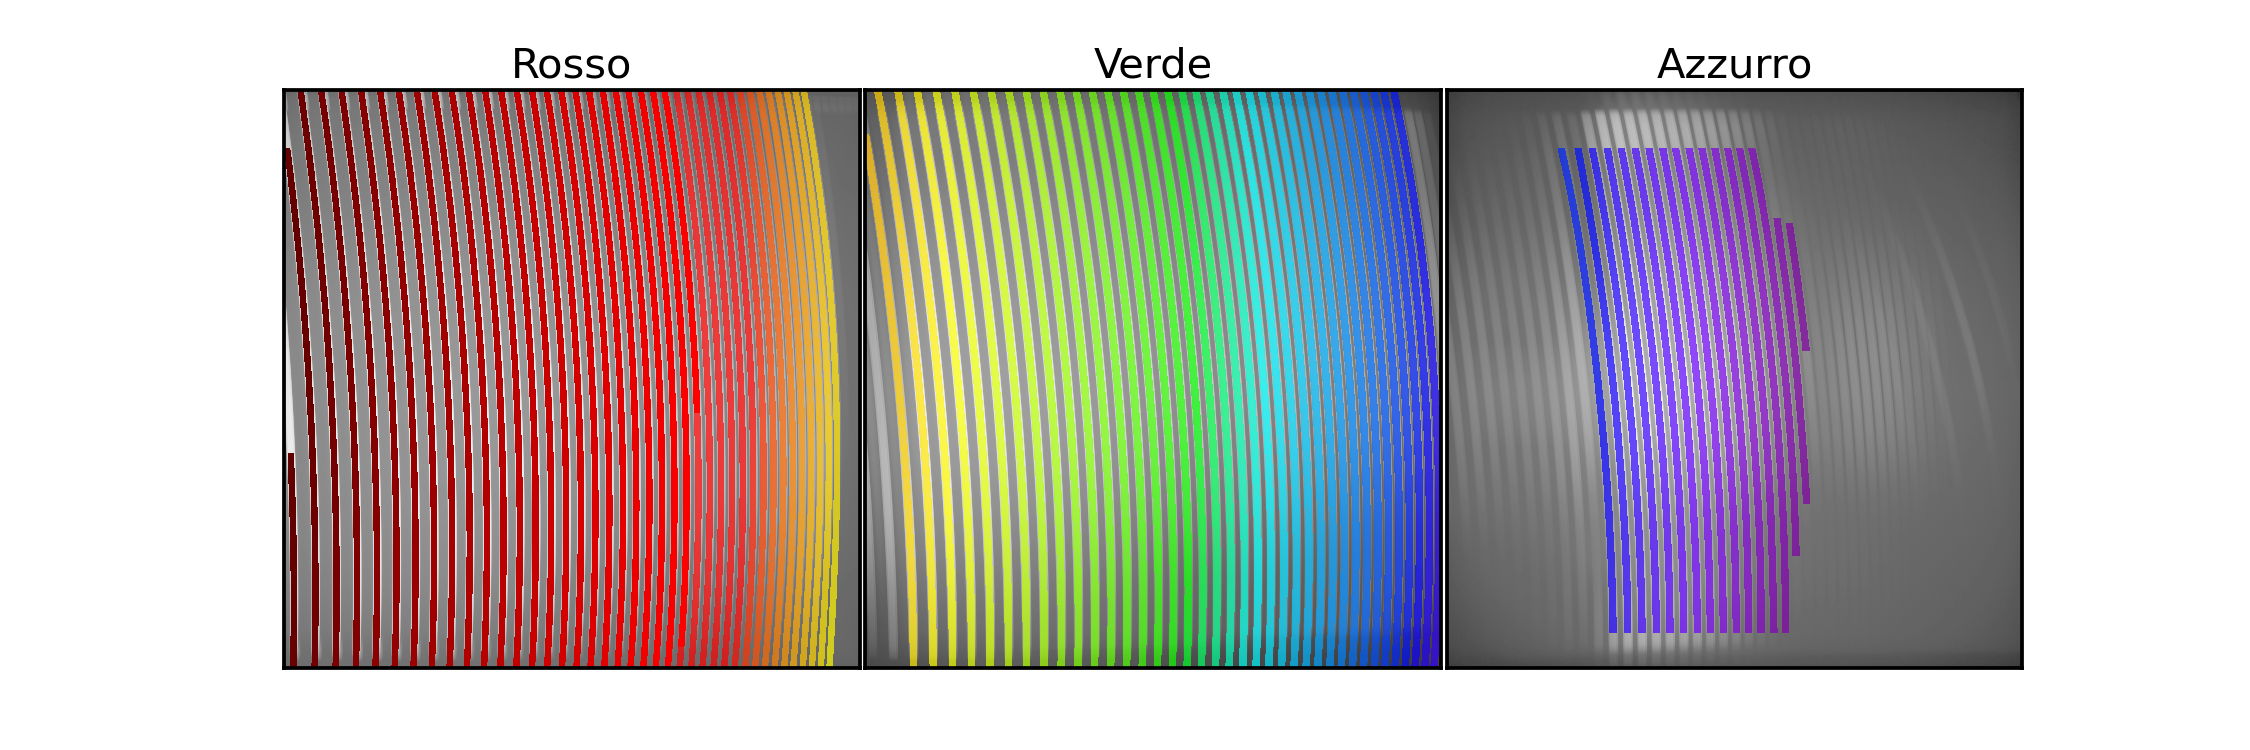

In [16]:
master_path = '/home/usqobserver2/Joachim_veloce/Extracted_data/HD20203/Intermediate_results/Master/'
arms = ['red', 'green', 'blue']

master_flats = []
arm_traces = []
arm_waves = []
for arm in arms:
    master_flats.append(fits.open(os.path.join(master_path, f'master_flat_{arm}_230824.fits'))[0].data)
    arm_trace_filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl')
    _trace = veloce_reduction_tools.Traces.load_traces(arm_trace_filename)
    arm_traces.append(_trace)
    ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm=arm)
    arm_waves.append(veloce_reduction_tools.calibrate_orders_to_wave(None, Y0, COEFFS, traces=_trace))

# use common scaling for visual comparison (1st-99th percentiles)
stack = np.array([mf.astype(float) for mf in master_flats])
# vmin, vmax = np.percentile(stack, 1), np.percentile(stack, 99)

plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
label_map = {'red': 'Rosso', 'green': 'Verde', 'blue': 'Azzurro'}
for ax, mf, arm in zip(axes, master_flats, arms):
    im = ax.imshow(mf, origin='lower', cmap='gray', norm='symlog', aspect='equal')
    ax.set_title(f"{label_map.get(arm, arm)}")
    ax.set_xticks([])
    ax.set_yticks([])

    # build wavelength overlay (proxy_data holds wavelength, mask marks covered pixels)
    _traces = arm_traces[arms.index(arm)]
    waves_list = arm_waves[arms.index(arm)]

    # create an RGBA image (M,N,4) filled with zeros => fully transparent
    proxy_data = np.zeros(mf.shape + (4,), dtype=float)
    # print(proxy_data.shape)

    # mask = np.zeros_like(mf, dtype=bool)

    # iterate orders; traces.y/x are per-order arrays
    for order_idx, (trace_y, trace_x, lower, upper) in enumerate(zip(_traces.y, _traces.x,
                                                                     _traces.summing_ranges_lower,
                                                                     _traces.summing_ranges_upper)):
        # get wavelength array for this order if available
        wave_order = waves_list[order_idx]
        # print(len(trace_y), len(trace_x), len(wave_order))
        min_y = np.nanmin(trace_y)

        for y, x in zip(trace_y, trace_x):
            x_min = max(int(x - lower), 0)
            x_max = min(int(x + upper), mf.shape[1]-1)
            # mask[int(y), x_min:x_max] = True
            if np.isnan(y) or np.isnan(x):
                print(f"NaN in trace at order {order_idx}, y={y}, x={x}")
                continue
            w = wave_order[int(y-min_y)]
            proxy_data[int(y), x_min:x_max] = wavelength_to_rgb(w)

    # overlay the wavelength mask on top of the master flat for visual inspection
    # masked_waves = np.ma.masked_where(~mask, proxy_data)
    # if masked_waves.count() > 0:
    #     wmin, wmax = np.nanmin(masked_waves), np.nanmax(masked_waves)
    #     _cmap = wavelength_cmap(wmin, wmax)
    overlay = ax.imshow(proxy_data, origin='lower', aspect='equal', interpolation='none')

# Apply the mask to proxy_data
# masked_proxy_data = np.ma.masked_where(~mask, proxy_data)

plt.subplots_adjust(wspace=0, hspace=0)
# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
# plt.tight_layout()
plt.show()
# plt.savefig(f'../Plots/Veloce_arms_wavelength_coded_396-940.png')